### GFMS:
http://flood.umd.edu  
http://eagle2.umd.edu/flood/download/  subfolder: [year][yearmm]  
Flood_byStor_yyyymmddhh.bin  Flood intensity (in depth) above threshold mm  

In [1]:
from datetime import date
import requests, wget
import os, sys

In [2]:
baseurl = "http://eagle2.umd.edu/flood/download/"
# find the latest data set
cur_year, cur_month = map(str,[date.today().year,date.today().month])
cur_month = cur_month.zfill(2)
dataurl = baseurl + cur_year + "/" + cur_year + cur_month 
print(dataurl)

http://eagle2.umd.edu/flood/download/2020/202001


In [3]:
response = requests.get(dataurl)
raw_text = response.text.split()
data_list = [x.split("'")[1] for x in raw_text if "href" in x]
latest_data = data_list[-2]
latest_data_url = dataurl + "/" + latest_data
print(latest_data_url)

http://eagle2.umd.edu/flood/download/2020/202001/Flood_byStor_2020011318.bin


In [4]:
if not os.path.exists(latest_data):
    wget.download(latest_data_url)

In [5]:
# generate header file
hdr_header = """NCOLS 2458
NROWS 800
XLLCORNER -127.25
YLLCORNER -50
CELLSIZE 0.125
PIXELTYPE FLOAT
BYTEORDER LSBFIRST
NODATA_VALUE -9999
"""
header_file = latest_data.replace(".bin",".hdr")
with open(header_file,"w") as f:
    f.write(hdr_header)

In [6]:
vrt_template="""<VRTDataset rasterXSize="2458" rasterYSize="800">
  <SRS>GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]</SRS>
  <GeoTransform> -1.2725000000000000e+02,  1.2500000000000000e-01,  0.0000000000000000e+00,  5.0000000000000000e+01,  0.0000000000000000e+00, -1.2500000000000000e-01</GeoTransform>
  <VRTRasterBand dataType="Float32" band="1">
    <Metadata>
      <MDI key="STATISTICS_APPROXIMATE">YES</MDI>
      <MDI key="STATISTICS_MAXIMUM">1345.408203125</MDI>
      <MDI key="STATISTICS_MEAN">26.161176808621</MDI>
      <MDI key="STATISTICS_MINIMUM">1.1765951057896e-07</MDI>
      <MDI key="STATISTICS_STDDEV">120.73468295071</MDI>
      <MDI key="STATISTICS_VALID_PERCENT">1.117</MDI>
    </Metadata>
    <NoDataValue>-9999</NoDataValue>
    <ComplexSource>
      <SourceFilename relativeToVRT="1">{}</SourceFilename>
      <SourceBand>1</SourceBand>
      <SourceProperties RasterXSize="2458" RasterYSize="800" DataType="Float32" BlockXSize="2458" BlockYSize="1" />
      <SrcRect xOff="0" yOff="0" xSize="2458" ySize="800" />
      <DstRect xOff="0" yOff="0" xSize="2458" ySize="800" />
      <NODATA>-9999</NODATA>
    </ComplexSource>
  </VRTRasterBand>
</VRTDataset>"""

In [7]:
# generate VRT file
vrt_file = latest_data.replace(".bin",".vrt")
with open(vrt_file,"w") as f:
    f.write(vrt_template.format(latest_data))

check the vrt file with gdalinfo
!gdalinfo {vrt_file}

Driver: VRT/Virtual Raster
Files: Flood_byStor_2020011318.vrt
       Flood_byStor_2020011318.bin
Size is 2458, 800
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]
Origin = (-127.250000000000000,50.000000000000000)
Pixel Size = (0.125000000000000,-0.125000000000000)
Corner Coordinates:
Upper Left  (-127.2500000,  50.0000000) (127d15' 0.00"W, 50d 0' 0.00"N)
Lower Left  (-127.2500000, -50.0000000) (127d15' 0.00"W, 50d 0' 0.00"S)
Upper Right ( 180.0000000,  50.0000000) (180d 0' 0.00"E, 50d 0' 0.00"N)
Lower Right ( 180.0000000, -50.0000000) (180d 0' 0.00"E, 50d 0' 0.00"S)
Center      (  26.3750000,   0.0000000) ( 26d22'30.00"E,  0d 0' 0.01"N)
Band 1 Block=128x128 Type=Float32, ColorInterp=Undefined
  Min=0.000 Max=1345.408 
  Minimum=0.000, Maximum=1345.408, Mean=26.161, StdDev=120.735
  NoData Value=-9999
  Metadata:
    STATISTICS_APPROXIMATE=YES
    STATISTICS_MAXIMUM=1345.408203125
    STATISTICS_MEAN=26.161176808621
    STATISTICS_MINIMUM=1.1765951057896e-07
    STATISTICS_STDDEV=120.73468295071
    STATISTICS_VALID_PERCENT=1.117

In [16]:
###The usual python imports for the notebook
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np

In [17]:
plt.rcParams["figure.figsize"] = (20,10)

gdal.UseExceptions()

#Utility function to load data
def loadData(infile, band=1):
    ds = gdal.Open(infile, gdal.GA_ReadOnly)
    #Data array
    data = ds.GetRasterBand(band).ReadAsArray()
    #Map extent
    trans = ds.GetGeoTransform()
    xsize = ds.RasterXSize
    ysize = ds.RasterYSize
    extent = [trans[0], trans[0] + xsize * trans[1],
            trans[3] + ysize*trans[5], trans[3]]
    
    ds = None
    return data, extent

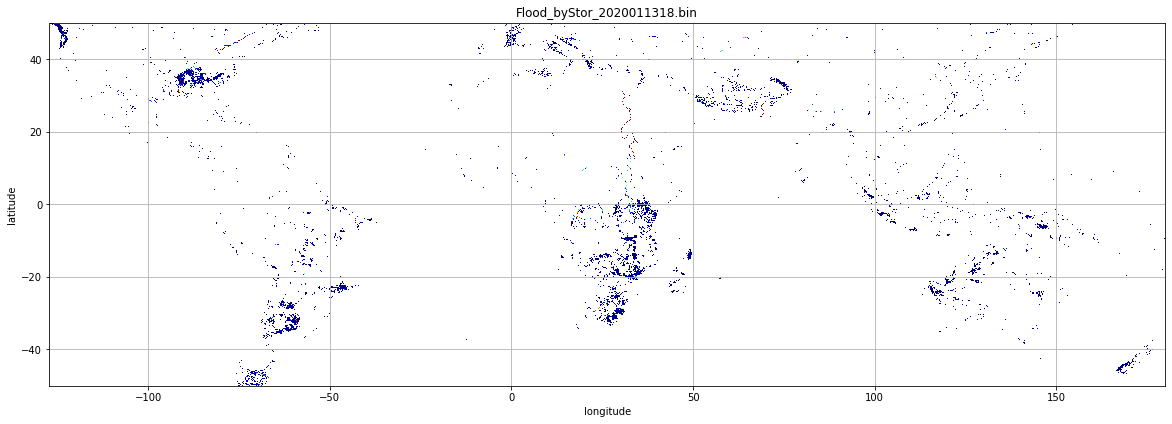

In [18]:
vrt_nodata = -9999.0
vrt_data, vrt_ext = loadData(vrt_file)
vrt_data[vrt_data == vrt_nodata] = np.nan
fig,ax = plt.subplots()
ax.set(xlabel='longitude',ylabel='latitude',title = latest_data)
img_plot = plt.imshow(vrt_data, extent=vrt_ext,cmap="jet",vmin=0.01,vmax=200.0)
ax.grid(True)
#ax.set_aspect(1.5)
plt.show()

### Watersheds
https://www.wri.org/resources/data-sets/aqueduct-global-maps-30-data

In [11]:
watersheds_gdb = 'WRIWatersheds.gdb'
# ogrinfo WRIWatersheds.gdb/
#1: aqid_watersheds_wrisk (Multi Polygon)
from osgeo import ogr
driver = ogr.GetDriverByName('OpenFileGDB')
ds = driver.Open(watersheds_gdb,0)
layer = ds.GetLayer()
featureCount = layer.GetFeatureCount() 
print(layer.GetName(),featureCount)

aqid_watersheds_wrisk 3401


In [12]:
# use geopandas
import geopandas
watersheds = geopandas.read_file(watersheds_gdb)
watersheds.head()

,aqid,FIRST_aqid,FIRST_gid_0,FIRST_name_0,FIRST_name_1,SUM_area_km2,MEAN_rfr_score,MEAN_cfr_score,Shape_Length,Shape_Area,geometry
0,-9999,-9999,EGY,Egypt,As Suways,855919.290693,2.116889,1.17131,14329.046938,163.155967,"MULTIPOLYGON (((-67.247 -55.934, -67.245 -55.9..."
1,1,1,GRL,Greenland,Northeast Greenland National Park,76.115674,0.000000,0.00000,1.473418,0.052678,"MULTIPOLYGON (((-38.903 83.291, -39.031 83.286..."
2,2,2,GRL,Greenland,Northeast Greenland National Park,209.303431,0.000000,0.00000,4.145705,0.143175,"MULTIPOLYGON (((-40.499 83.359, -40.454 83.357..."
3,3,3,GRL,Greenland,Northeast Greenland National Park,15.278516,0.000000,0.00000,0.915296,0.010402,"MULTIPOLYGON (((-41.233 83.306, -41.253 83.285..."
4,4,4,GRL,Greenland,Northeast Greenland National Park,15.816344,0.000000,0.00000,0.921070,0.010673,"MULTIPOLYGON (((-42.184 83.270, -42.149 83.269..."


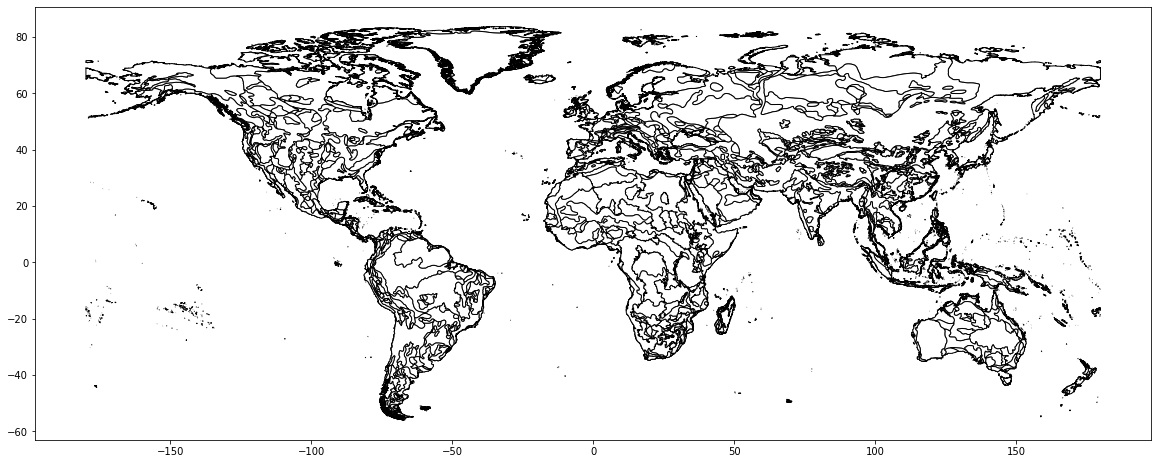

In [19]:
watersheds.plot(color='white', edgecolor='black')

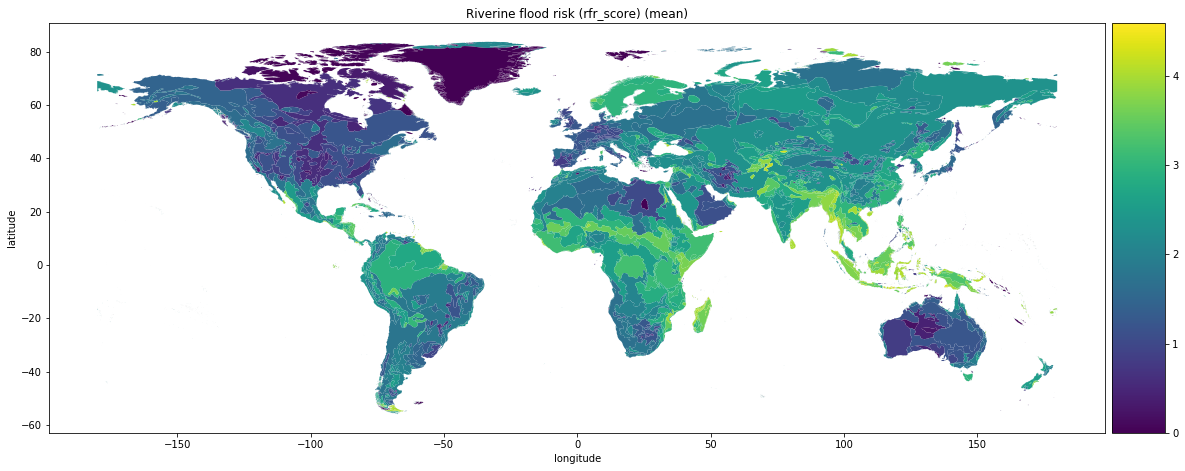

In [20]:
#MEAN_rfr_score Riverine flood risk (rfr_score) (mean)
#MEAN_cfr_score Coastal flood risk (cfr_score) (mean)
watersheds = watersheds[watersheds.MEAN_rfr_score.notnull()]
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax.set(xlabel='longitude',ylabel='latitude',title = "Riverine flood risk (rfr_score) (mean)")
watersheds.plot(column='MEAN_rfr_score', ax=ax, legend=True, cax=cax)

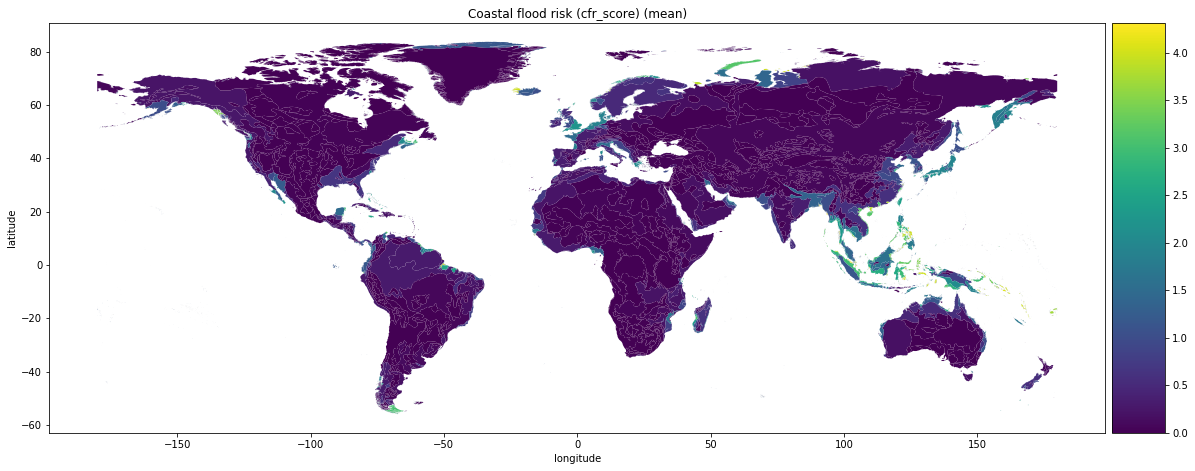

In [21]:
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax.set(xlabel='longitude',ylabel='latitude',title = "Coastal flood risk (cfr_score) (mean)")
watersheds.plot(column='MEAN_cfr_score', ax=ax, legend=True, cax=cax)